# Evaluate the calibration results

In [1]:
from impact_calc import *
from climada.util import log_level

log_level("WARNING")

## Plot Impact Functions

Loading hazard
2025-03-05 11:43:40,548 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth'
2025-03-05 11:43:40,861 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2025-03-05 11:43:40,863 - climada.hazard.io - DEBUG - Using default values for Hazard.fraction. No data found
2025-03-05 11:43:40,864 - climada.hazard.io - DEBUG - Using default values for Hazard.frequency. No data found
2025-03-05 11:43:40,865 - climada.hazard.io - DEBUG - Using default values for Hazard.event_id. No data found
2025-03-05 11:43:40,865 - climada.hazard.io - DEBUG - Using default values for Hazard.event_name. No data found
2025-03-05 11:43:40,866 - climada.hazard.io - DEBUG - Reading data for Hazard.date from DataArray 'time'
2025-03-05 11:43:40,867 - climada.hazard.io - DEBUG - Hazard successfully loaded. Number of events: 16
Loading exposure
2025-03-05 11:43:40,876 - climada.util.coordinates - INFO - Reading /cl

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 11:43:52,082 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
2025-03-05 11:43:59,676 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2025-03-05 11:43:59,677 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2025-03-05 11:43:59,677 - climada.entity.exposures.base - INFO - Matching 2497422 exposures with 2522304 centroids.
2025-03-05 11:44:00,244 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-03-05 11:44:05,855 - climada.engine.impact_calc - INFO - Calculating impact for 3997836 assets (>0) and 16 events.
Loading hazard
2025-03-05 11:44:08,660 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth_flopros'
2025-03-05 11:44:09,233 - climada.hazard.io - WARNING - 

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 11:44:22,410 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
2025-03-05 11:44:29,999 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2025-03-05 11:44:30,000 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2025-03-05 11:44:30,001 - climada.entity.exposures.base - INFO - Matching 2497422 exposures with 2522304 centroids.
2025-03-05 11:44:30,596 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-03-05 11:44:36,231 - climada.engine.impact_calc - INFO - Calculating impact for 3997836 assets (>0) and 16 events.
Loading hazard
2025-03-05 11:44:38,805 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth'
2025-03-05 11:44:39,876 - climada.hazard.io - WARNING - Failed t

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 11:44:50,798 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
2025-03-05 11:44:56,953 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2025-03-05 11:44:56,954 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2025-03-05 11:44:56,955 - climada.entity.exposures.base - INFO - Matching 2051161 exposures with 2086560 centroids.
2025-03-05 11:44:57,424 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-03-05 11:45:01,940 - climada.engine.impact_calc - INFO - Calculating impact for 2244510 assets (>0) and 16 events.
Loading hazard
2025-03-05 11:45:03,290 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth_flopros'
2025-03-05 11:45:03,608 - climada.hazard.io - WARNING - 

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 11:45:13,934 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
2025-03-05 11:45:20,293 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2025-03-05 11:45:20,293 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2025-03-05 11:45:20,294 - climada.entity.exposures.base - INFO - Matching 2051161 exposures with 2086560 centroids.
2025-03-05 11:45:20,804 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-03-05 11:45:25,398 - climada.engine.impact_calc - INFO - Calculating impact for 2244510 assets (>0) and 16 events.
Loading hazard
2025-03-05 11:45:28,055 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth'
2025-03-05 11:45:29,529 - climada.hazard.io - WARNING - Failed t

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 11:45:47,204 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
2025-03-05 11:45:57,365 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2025-03-05 11:45:57,366 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2025-03-05 11:45:57,366 - climada.entity.exposures.base - INFO - Matching 3308040 exposures with 3309696 centroids.
2025-03-05 11:45:58,121 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-03-05 11:46:05,502 - climada.engine.impact_calc - INFO - Calculating impact for 6778869 assets (>0) and 16 events.
Loading hazard
2025-03-05 11:46:07,812 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth_flopros'
2025-03-05 11:46:08,088 - climada.hazard.io - WARNING - 

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 11:46:22,891 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input


/cluster/software/stacks/2024-06/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-12.2.0/python-3.11.6-ukhwpjnwzzzizek3pgr75zkbhxros5fq/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


2025-03-05 11:46:32,916 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2025-03-05 11:46:32,917 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2025-03-05 11:46:32,918 - climada.entity.exposures.base - INFO - Matching 3308040 exposures with 3309696 centroids.
2025-03-05 11:46:33,702 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2025-03-05 11:46:41,222 - climada.engine.impact_calc - INFO - Calculating impact for 6778869 assets (>0) and 16 events.


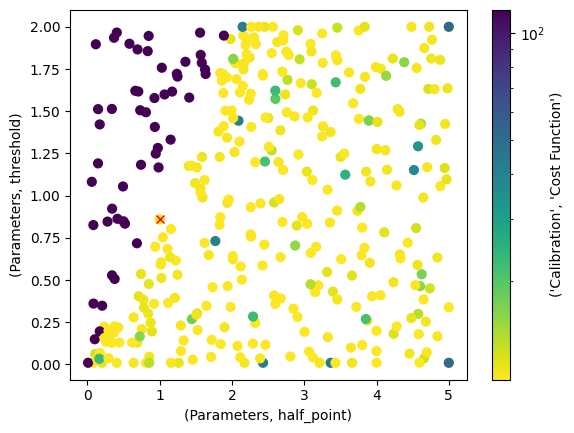

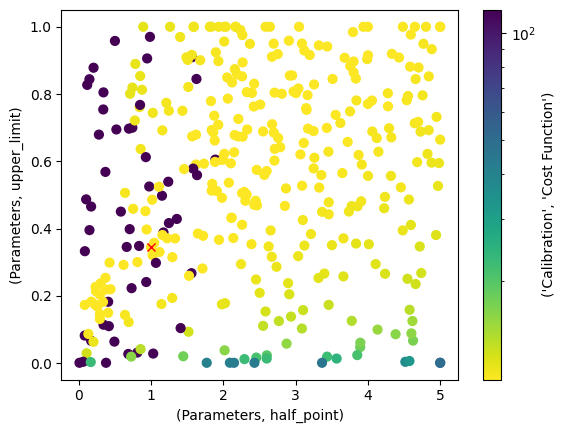

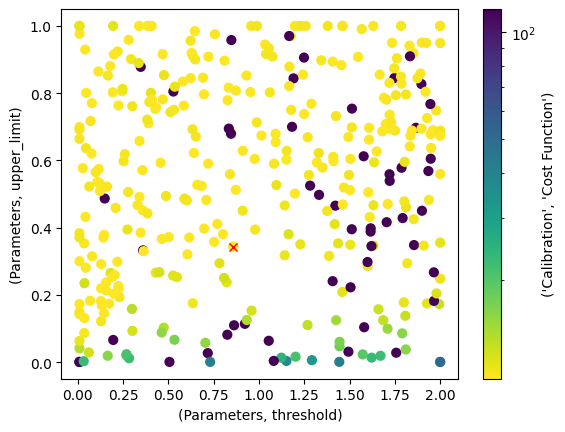

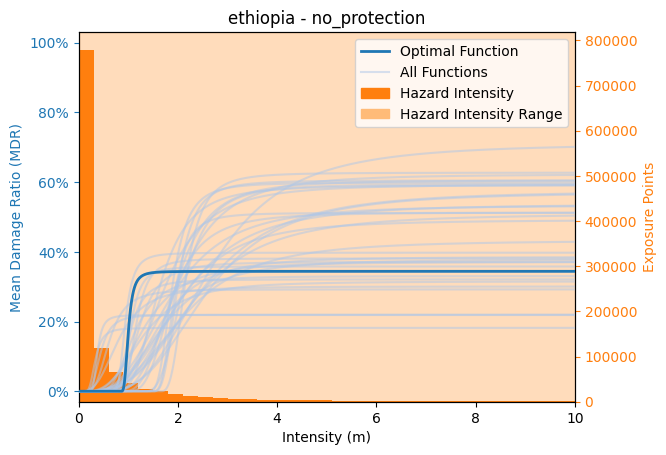

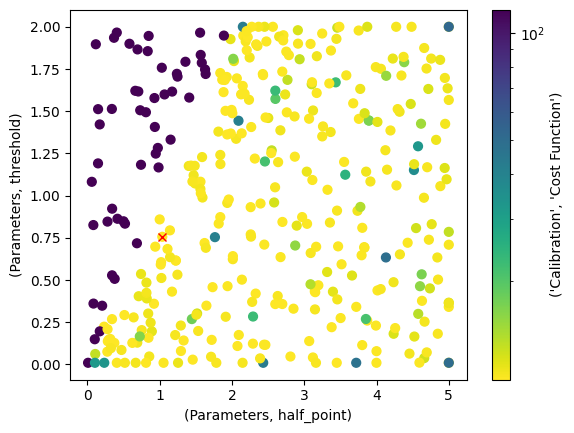

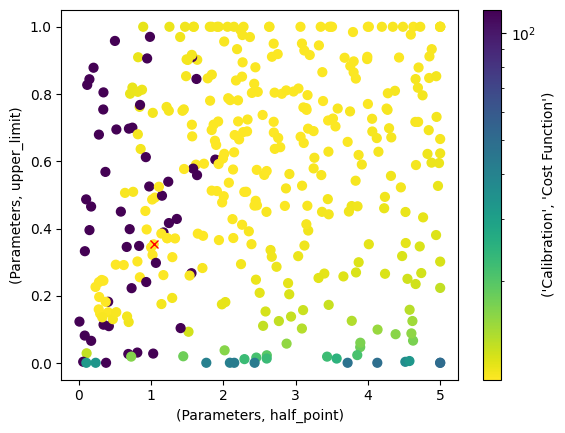

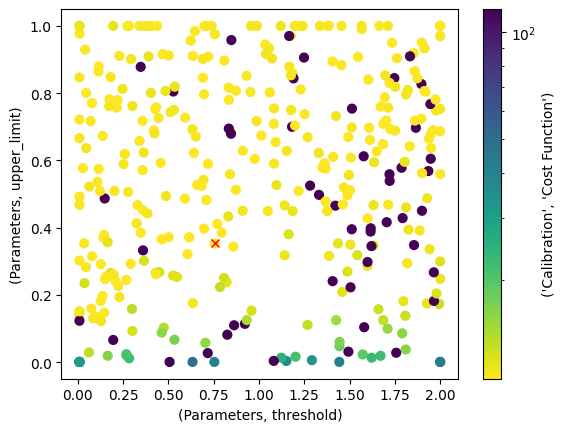

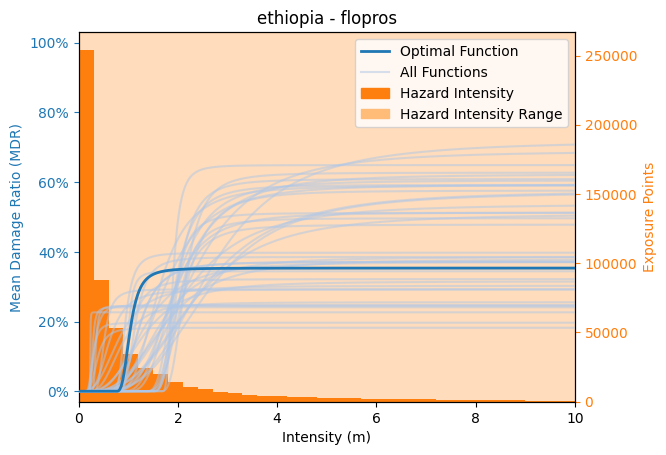

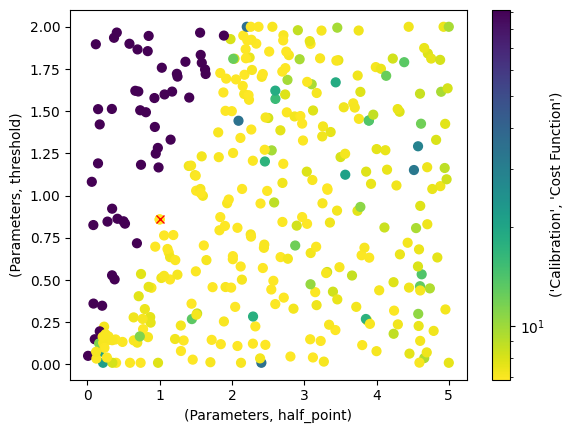

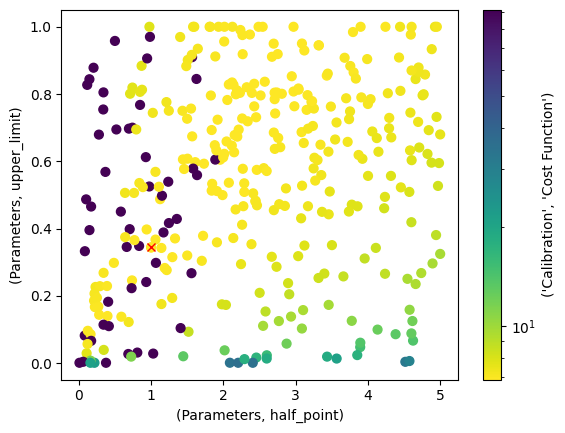

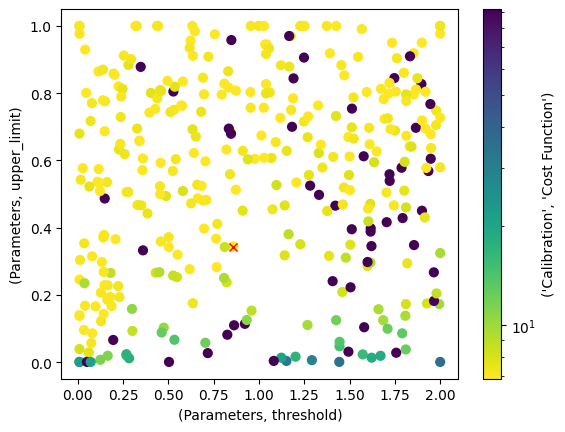

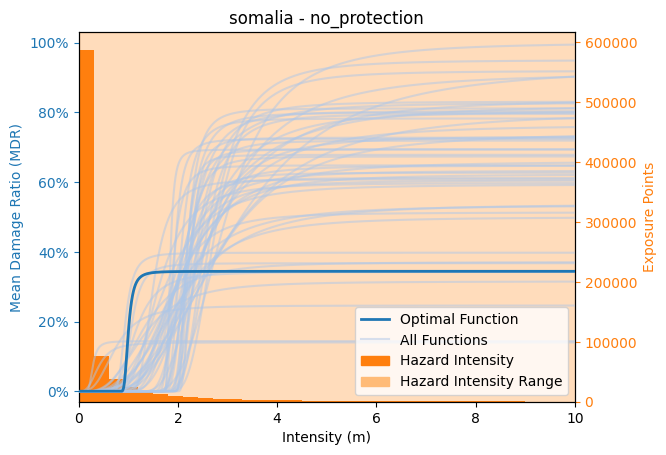

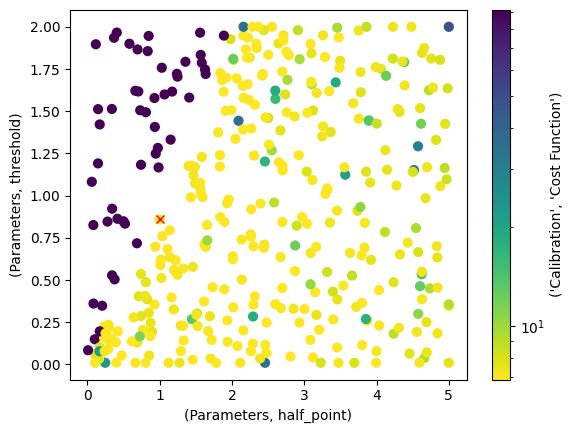

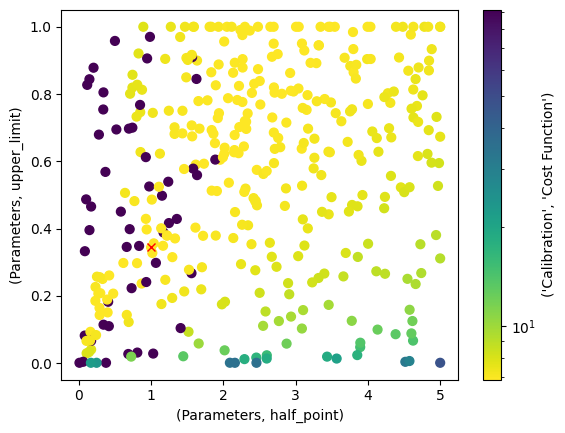

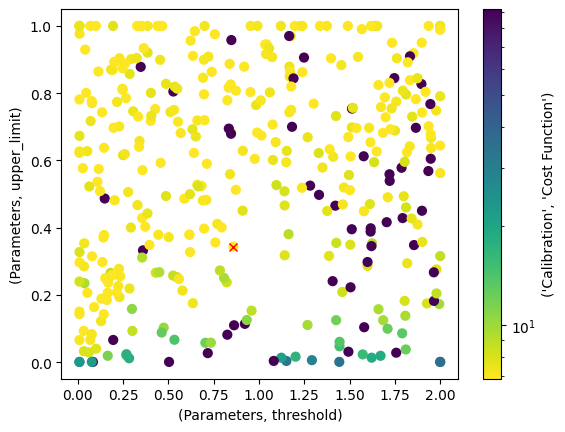

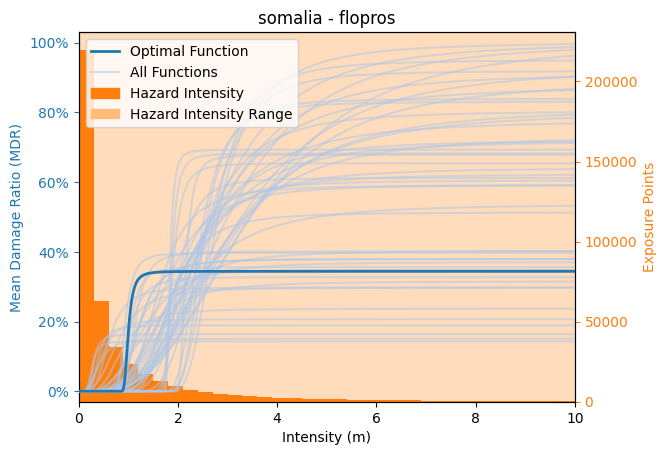

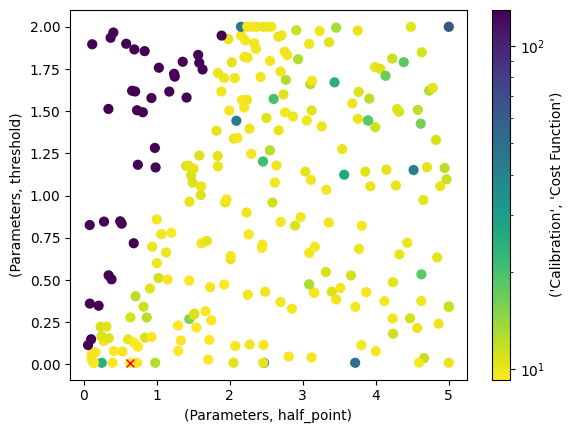

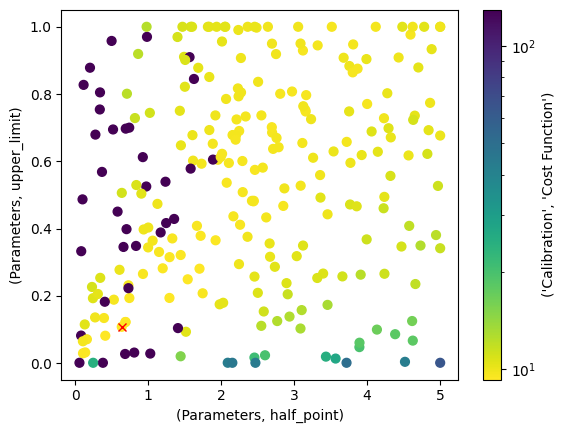

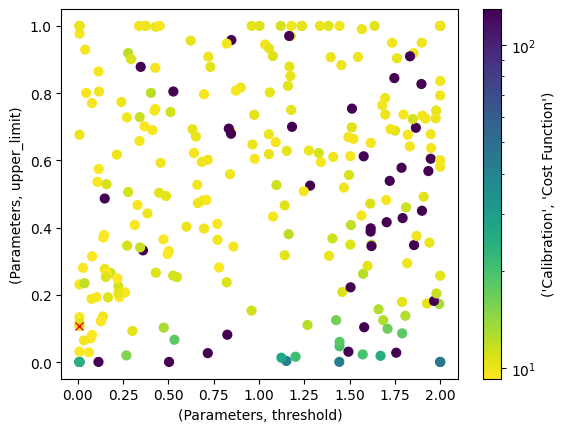

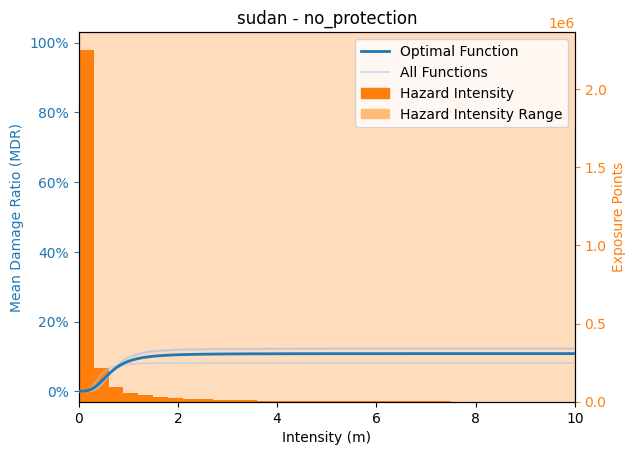

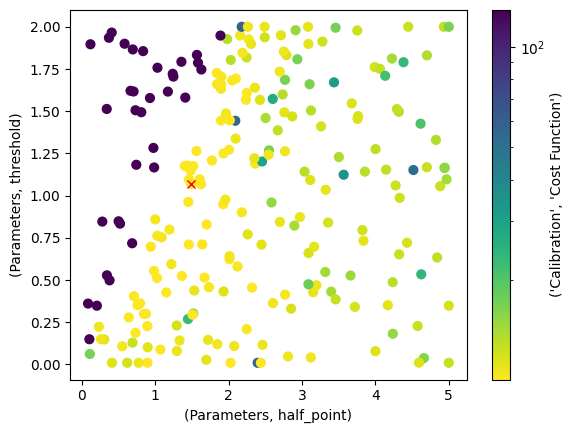

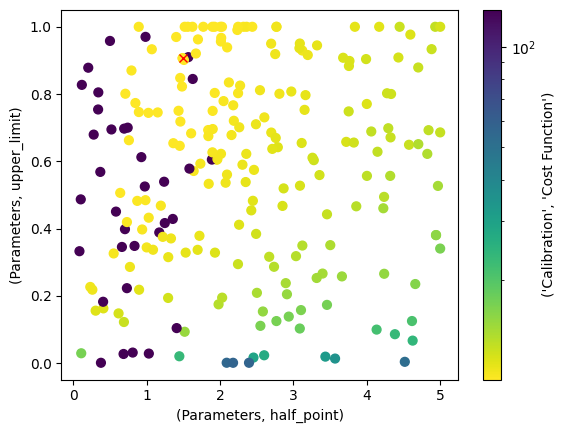

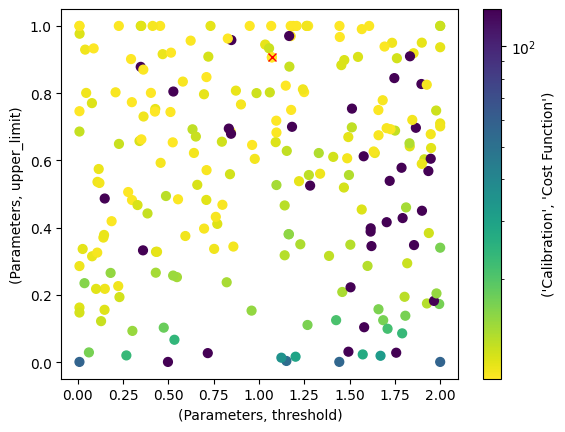

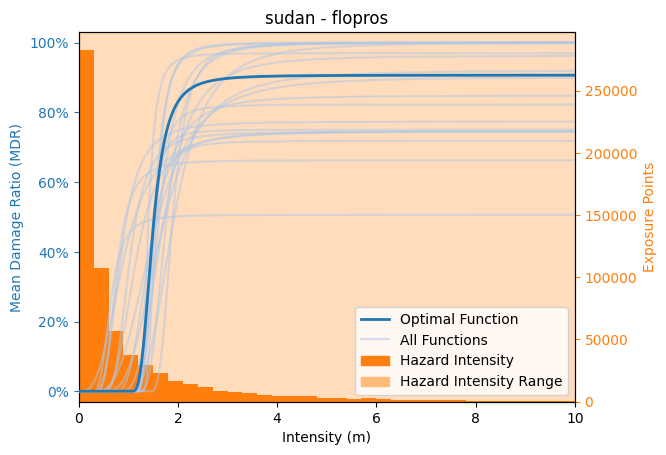

In [3]:
from itertools import product
import pandas
import matplotlib.colors as mcolors

from climada.util.calibrate import BayesianOptimizerOutputEvaluator
from climada.util.calibrate.bayesian_optimizer import (
    BayesianOptimizerOutput,
    select_best,
)

countries = ("ethiopia", "somalia", "sudan")
protection = ("no_protection", "flopros")

for ctry, prot in product(countries, protection):
    intensity = "flood_depth" if prot == "no_protection" else "flood_depth_flopros"
    inp = calibration_input(ctry, intensity, "sigmoid")
    inp.exposure = inp.exposure[2020]

    # p_space = pd.read_hdf(
    #     f"data/generated/{ctry}/calibration/sigmoid-pspace.h5", key=prot
    # ).sort_values(("Calibration", "Cost Function"))
    # params = p_space["Parameters"].iloc[0]
    # out_eval = BayesianOptimizerOutputEvaluator(
    #     output=BayesianOptimizerOutput(params, None, None), input=inp
    # )

    output = BayesianOptimizerOutput.from_hdf5(
        f"data/generated/{ctry}/sigmoid_all_new/pspace-{prot}.h5"
    )
    output.plot_p_space(norm=mcolors.LogNorm())
    out_eval = BayesianOptimizerOutputEvaluator(inp, output)
    ax = out_eval.plot_impf_variability(
        p_space_df=select_best(output.p_space_to_dataframe(), 0.007),
        plot_hist_kws={"bins": 100},
    )
    ax.set_title(f"{ctry} - {prot}")
    ax.set_xlim(left=0, right=10)
    ax.set_ylim(bottom=-3, top=103)

## Calculate Displacement Over Time

In [4]:
def impfsets_from_p_space(
    p_space_df, inp, cost_func_diff=0.007, num_samples=20, random_state=1
):
    """Return a list of impact function sets that represents the calibration uncertainty"""
    max_cost_func_val = p_space_df["Calibration", "Cost Function"].min() * (
        1 + cost_func_diff
    )
    params_within_range = p_space_df["Parameters"].loc[
        p_space_df["Calibration", "Cost Function"] <= max_cost_func_val
    ]
    params_within_range = params_within_range.sample(
        n=num_samples, replace=True, random_state=random_state
    )

    return [inp.impact_func_creator(**row) for _, row in params_within_range.iterrows()]

In [5]:
from itertools import product
import pandas as pd

from impact_calc import MultiExpImpactCalc
from climada.util import log_level
from climada.util.coordinates import country_to_iso
from climada.util.calibrate.bayesian_optimizer import BayesianOptimizerOutput

countries = ("ethiopia", "somalia", "sudan")
protection = ("no_protection", "flopros")

data_df = pd.DataFrame(
    columns=["Impact", "Year", "Country", "Protection", "Impact Func ID"]
)

for ctry, prot in product(countries, protection):
    intensity = "flood_depth" if prot == "no_protection" else "flood_depth_flopros"
    inp = calibration_input(ctry, intensity, "sigmoid")
    out = BayesianOptimizerOutput.from_hdf5(
        f"data/generated/{ctry}/sigmoid_all_new/pspace-{prot}.h5"
    )
    p_space = out.p_space_to_dataframe()
    # p_space = pd.read_hdf(
    #     f"data/generated/{ctry}/calibration-sigmoid-pspace.h5", key=prot
    # )

    with log_level("ERROR"):
        impacts = [
            MultiExpImpactCalc(inp.exposure, impf, inp.hazard).impact(
                assign_centroids=False, save_mat=False
            )
            for impf in impfsets_from_p_space(p_space, inp)
        ]

    for idx, impact in enumerate(impacts):
        data = pd.DataFrame.from_records(
            {
                "Impact": impact.at_event,
                "Year": impact.event_id,
                "Country": country_to_iso(ctry, representation="alpha3"),
                "Protection": prot,
                "Impact Func ID": idx,
            }
        )
        data_df = pd.concat([data_df, data], axis=0, ignore_index=True)

data_df

Loading hazard
2025-03-05 11:50:13,443 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth'
2025-03-05 11:50:14,746 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2025-03-05 11:50:14,748 - climada.hazard.io - DEBUG - Using default values for Hazard.fraction. No data found
2025-03-05 11:50:14,748 - climada.hazard.io - DEBUG - Using default values for Hazard.frequency. No data found
2025-03-05 11:50:14,749 - climada.hazard.io - DEBUG - Using default values for Hazard.event_id. No data found
2025-03-05 11:50:14,749 - climada.hazard.io - DEBUG - Using default values for Hazard.event_name. No data found
2025-03-05 11:50:14,750 - climada.hazard.io - DEBUG - Reading data for Hazard.date from DataArray 'time'
2025-03-05 11:50:14,750 - climada.hazard.io - DEBUG - Hazard successfully loaded. Number of events: 16
Loading exposure
2025-03-05 11:50:14,760 - climada.util.coordinates - INFO - Reading /cl

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 11:50:28,286 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input


/scratch/tmp.25264459.ldr.riedel/ipykernel_97757/345995582.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_df = pd.concat([data_df, data], axis=0, ignore_index=True)


Loading hazard
2025-03-05 11:56:28,601 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth_flopros'
2025-03-05 11:56:29,856 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2025-03-05 11:56:29,858 - climada.hazard.io - DEBUG - Using default values for Hazard.fraction. No data found
2025-03-05 11:56:29,858 - climada.hazard.io - DEBUG - Using default values for Hazard.frequency. No data found
2025-03-05 11:56:29,858 - climada.hazard.io - DEBUG - Using default values for Hazard.event_id. No data found
2025-03-05 11:56:29,859 - climada.hazard.io - DEBUG - Using default values for Hazard.event_name. No data found
2025-03-05 11:56:29,859 - climada.hazard.io - DEBUG - Reading data for Hazard.date from DataArray 'time'
2025-03-05 11:56:29,859 - climada.hazard.io - DEBUG - Hazard successfully loaded. Number of events: 16
Loading exposure
2025-03-05 11:56:29,869 - climada.util.coordinates - INFO - Rea

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 11:56:44,339 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
Loading hazard
2025-03-05 12:02:47,163 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth'
2025-03-05 12:02:48,297 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2025-03-05 12:02:48,300 - climada.hazard.io - DEBUG - Using default values for Hazard.fraction. No data found
2025-03-05 12:02:48,300 - climada.hazard.io - DEBUG - Using default values for Hazard.frequency. No data found
2025-03-05 12:02:48,301 - climada.hazard.io - DEBUG - Using default values for Hazard.event_id. No data found
2025-03-05 12:02:48,301 - climada.hazard.io - DEBUG - Using default values for Hazard.event_name. No data found
2025-03-05 12:02:48,302 - climada.hazard.io - DEBUG - Reading data for Hazard.date from DataArray 'time'
2025-03-

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 12:02:58,661 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
Loading hazard
2025-03-05 12:07:26,775 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth_flopros'
2025-03-05 12:07:27,088 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2025-03-05 12:07:27,090 - climada.hazard.io - DEBUG - Using default values for Hazard.fraction. No data found
2025-03-05 12:07:27,091 - climada.hazard.io - DEBUG - Using default values for Hazard.frequency. No data found
2025-03-05 12:07:27,092 - climada.hazard.io - DEBUG - Using default values for Hazard.event_id. No data found
2025-03-05 12:07:27,093 - climada.hazard.io - DEBUG - Using default values for Hazard.event_name. No data found
2025-03-05 12:07:27,094 - climada.hazard.io - DEBUG - Reading data for Hazard.date from DataArray 'time'


/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 12:07:35,893 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
Loading hazard
2025-03-05 12:12:05,439 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth'
2025-03-05 12:12:06,797 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2025-03-05 12:12:06,798 - climada.hazard.io - DEBUG - Using default values for Hazard.fraction. No data found
2025-03-05 12:12:06,799 - climada.hazard.io - DEBUG - Using default values for Hazard.frequency. No data found
2025-03-05 12:12:06,799 - climada.hazard.io - DEBUG - Using default values for Hazard.event_id. No data found
2025-03-05 12:12:06,799 - climada.hazard.io - DEBUG - Using default values for Hazard.event_name. No data found
2025-03-05 12:12:06,800 - climada.hazard.io - DEBUG - Reading data for Hazard.date from DataArray 'time'
2025-03-

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 12:12:22,711 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input
Loading hazard
2025-03-05 12:21:14,655 - climada.hazard.io - DEBUG - Loading Hazard intensity from DataArray 'flood_depth_flopros'
2025-03-05 12:21:15,819 - climada.hazard.io - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings
2025-03-05 12:21:15,821 - climada.hazard.io - DEBUG - Using default values for Hazard.fraction. No data found
2025-03-05 12:21:15,821 - climada.hazard.io - DEBUG - Using default values for Hazard.frequency. No data found
2025-03-05 12:21:15,822 - climada.hazard.io - DEBUG - Using default values for Hazard.event_id. No data found
2025-03-05 12:21:15,822 - climada.hazard.io - DEBUG - Using default values for Hazard.event_name. No data found
2025-03-05 12:21:15,823 - climada.hazard.io - DEBUG - Reading data for Hazard.date from DataArray 'time'


/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


2025-03-05 12:21:31,437 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
Creating input


,Impact,Year,Country,Protection,Impact Func ID
0,3.264587e+04,2008,ETH,no_protection,0
1,2.142905e+04,2009,ETH,no_protection,0
2,1.198775e+05,2010,ETH,no_protection,0
3,4.314297e+04,2011,ETH,no_protection,0
4,6.444457e+04,2012,ETH,no_protection,0
...,...,...,...,...,...
1915,1.556923e+06,2019,SDN,flopros,19
1916,1.742565e+06,2020,SDN,flopros,19
1917,2.713100e+05,2021,SDN,flopros,19
1918,1.805119e+05,2022,SDN,flopros,19


/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")
/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")
/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


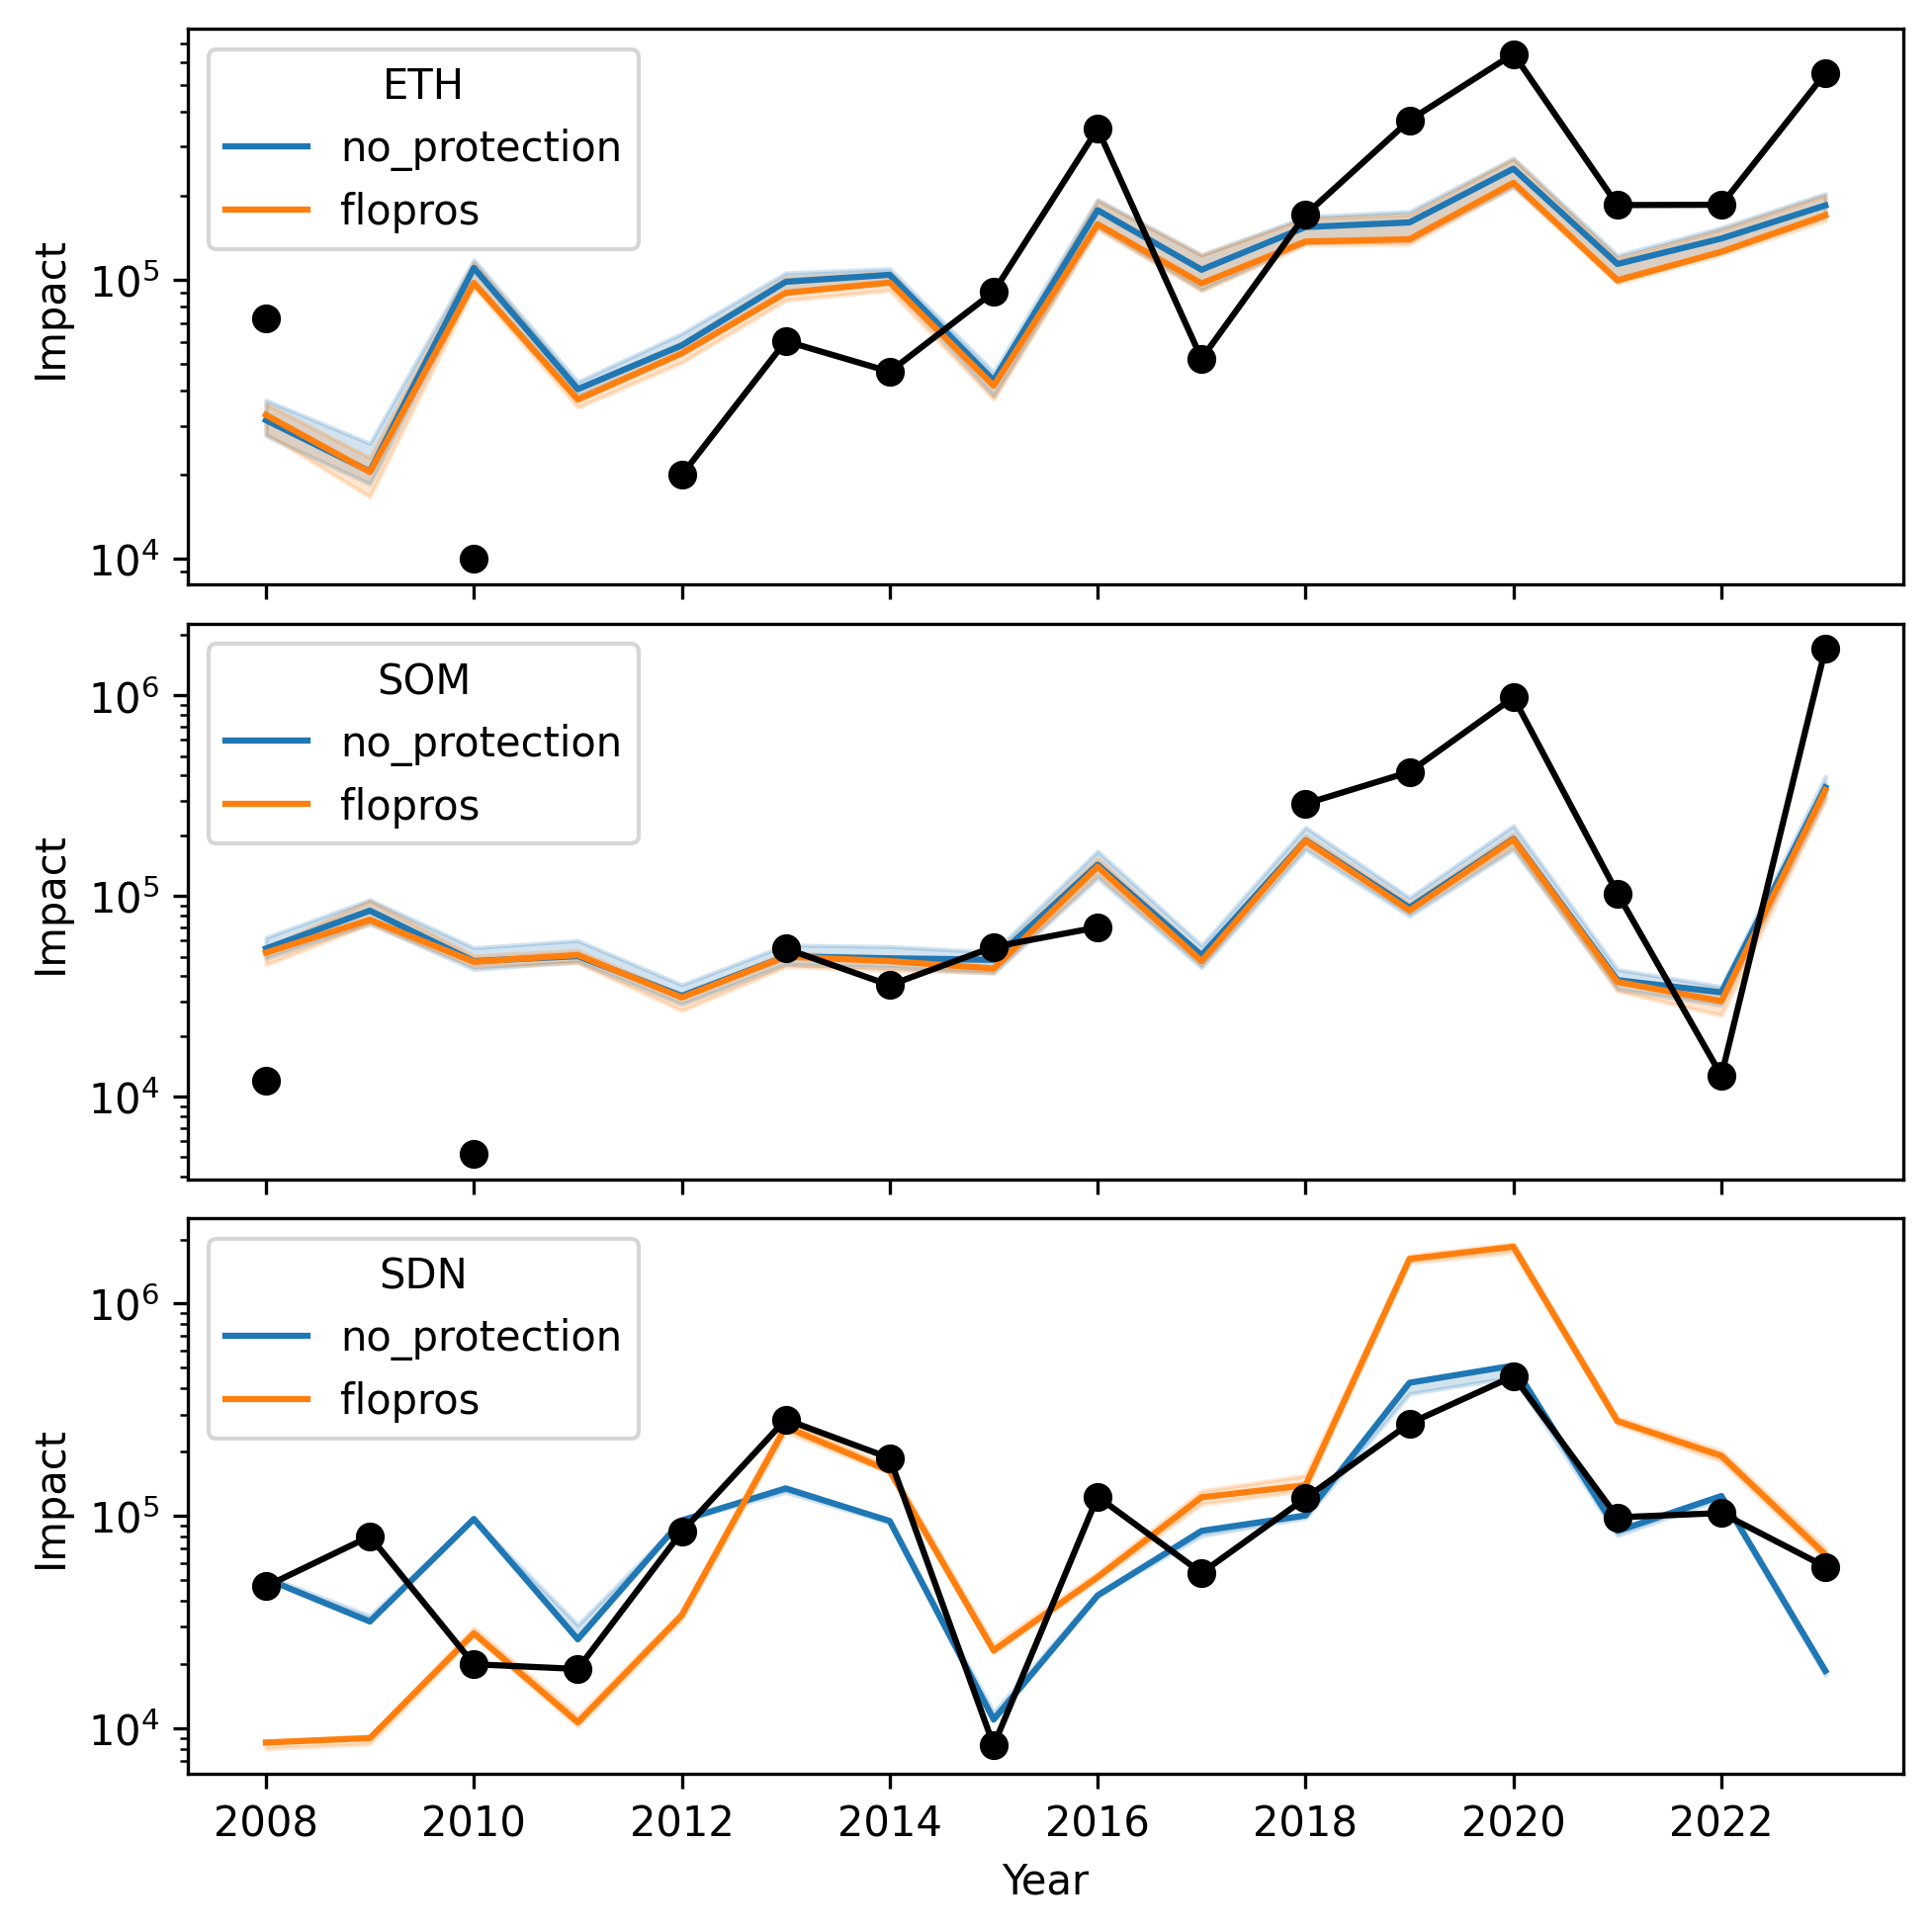

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(
    3, 1, constrained_layout=True, dpi=300, figsize=(6.4, 6.4), sharex=True
)
for country, ax in zip(data_df["Country"].unique(), axes):
    sns.lineplot(
        ax=ax,
        data=data_df.loc[data_df["Country"] == country],
        x="Year",
        y="Impact",
        hue="Protection",
        errorbar=("pi", 50),
        estimator="median",
        # legend=False if ax is not axes[0] else True,
    )
    data_displ = load_yearly_displacement_data(country, ignore_zero_impact=True)
    ax.plot(
        data_displ.index,
        data_displ[country_to_iso(country, representation="numeric")],
        color="k",
        marker="o",
        ls=None,
    )
    ax.set_yscale("log")
    ax.get_legend().set_title(country)

In [7]:
data_df = data_df.replace({"no_protection": "No Protection", "flopros": "FLOPROS"})
data_df

/scratch/tmp.25264459.ldr.riedel/ipykernel_97757/2662320059.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_df = data_df.replace({"no_protection": "No Protection", "flopros": "FLOPROS"})


,Impact,Year,Country,Protection,Impact Func ID
0,3.264587e+04,2008,ETH,No Protection,0
1,2.142905e+04,2009,ETH,No Protection,0
2,1.198775e+05,2010,ETH,No Protection,0
3,4.314297e+04,2011,ETH,No Protection,0
4,6.444457e+04,2012,ETH,No Protection,0
...,...,...,...,...,...
1915,1.556923e+06,2019,SDN,FLOPROS,19
1916,1.742565e+06,2020,SDN,FLOPROS,19
1917,2.713100e+05,2021,SDN,FLOPROS,19
1918,1.805119e+05,2022,SDN,FLOPROS,19


In [8]:
data_df.to_csv("displacement_per_year.csv", index=False)

In [9]:
pd.read_csv("displacement_per_year.csv")

,Impact,Year,Country,Protection,Impact Func ID
0,3.264587e+04,2008,ETH,No Protection,0
1,2.142905e+04,2009,ETH,No Protection,0
2,1.198775e+05,2010,ETH,No Protection,0
3,4.314297e+04,2011,ETH,No Protection,0
4,6.444457e+04,2012,ETH,No Protection,0
...,...,...,...,...,...
1915,1.556923e+06,2019,SDN,FLOPROS,19
1916,1.742565e+06,2020,SDN,FLOPROS,19
1917,2.713100e+05,2021,SDN,FLOPROS,19
1918,1.805119e+05,2022,SDN,FLOPROS,19


In [10]:
load_yearly_displacement_data("SOM", ignore_zero_impact=True)

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


,706
year,
2008,12000.0
2009,NaN
2010,5200.0
2011,NaN
2012,NaN
2013,54800.0
2014,36040.0
2015,55900.0
2016,70000.0


In [11]:
import numpy as np
from scipy.stats import gumbel_r


def calc_pmd(at_event, return_periods):
    # Sort descendingly the impacts per events
    sort_idxs = np.argsort(at_event)[::-1]
    # Calculate exceedence frequency
    exceed_freq = np.cumsum(np.ones_like(at_event, dtype="float") / at_event.size)
    # Set return period and impact exceeding frequency
    ifc_return_per = 1 / exceed_freq[::-1]
    ifc_impact = at_event[sort_idxs][::-1]

    return np.interp(return_periods, ifc_return_per, ifc_impact)


def calc_pmd_full(at_event):
    # Sort descendingly the impacts per events
    sort_idxs = np.argsort(at_event)[::-1]
    # Calculate exceedence frequency
    exceed_freq = np.cumsum(np.ones_like(at_event, dtype="float") / at_event.size)
    # Set return period and impact exceeding frequency
    ifc_return_per = 1 / exceed_freq[::-1]
    ifc_impact = at_event[sort_idxs][::-1]

    return ifc_return_per, ifc_impact

Total displacement

In [12]:
# grouped = data_df.groupby(["Country", "Protection", "Impact Func ID"])

# Remove years 2022 and 2023
grouped = data_df.loc[~data_df["Year"].isin([2022, 2023]), :].groupby(["Country", "Protection", "Impact Func ID"])

In [13]:
from climada.util.coordinates import country_to_iso

sum_df = pd.DataFrame.from_records(
    [
        name + (data_df.loc[idx, "Impact"].sum(),)
        for name, idx in grouped.groups.items()
    ],
    columns=["Country", "Protection", "Impact Func ID", "Total Impact"],
)
# sum_df.to_csv("")
sum_df

,Country,Protection,Impact Func ID,Total Impact
0,ETH,FLOPROS,0,1.271437e+06
1,ETH,FLOPROS,1,1.294217e+06
2,ETH,FLOPROS,2,1.309475e+06
3,ETH,FLOPROS,3,1.396023e+06
4,ETH,FLOPROS,4,1.234684e+06
...,...,...,...,...
115,SOM,No Protection,15,1.333722e+06
116,SOM,No Protection,16,1.218271e+06
117,SOM,No Protection,17,1.276031e+06
118,SOM,No Protection,18,9.681481e+05


In [14]:
sum_df = pd.concat(
    [
        sum_df,
        pd.DataFrame.from_records(
            [
                (
                    ctry,
                    "Reported",
                    0,
                    load_yearly_displacement_data(ctry)[
                        country_to_iso(ctry, "numeric")
                    ].sum(),
                )
                for ctry in ["ETH", "SOM", "SDN"]
            ],
            columns=["Country", "Protection", "Impact Func ID", "Total Impact"],
        ),
    ],
    axis=0,
    ignore_index=True,
)
sum_df

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")
/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")
/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


,Country,Protection,Impact Func ID,Total Impact
0,ETH,FLOPROS,0,1.271437e+06
1,ETH,FLOPROS,1,1.294217e+06
2,ETH,FLOPROS,2,1.309475e+06
3,ETH,FLOPROS,3,1.396023e+06
4,ETH,FLOPROS,4,1.234684e+06
...,...,...,...,...
118,SOM,No Protection,18,9.681481e+05
119,SOM,No Protection,19,1.310574e+06
120,ETH,Reported,0,2.806604e+06
121,SOM,Reported,0,3.745135e+06


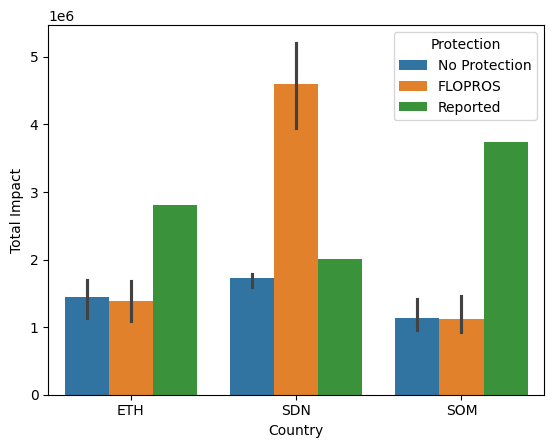

In [15]:
ax = sns.barplot(
    data=sum_df,
    x="Country",
    y="Total Impact",
    hue="Protection",
    errorbar="pi",
    hue_order=["No Protection", "FLOPROS", "Reported"],
)
# ax.set_yscale("log")

Average Annual Displacement

Text(0, 0.5, 'AAD')

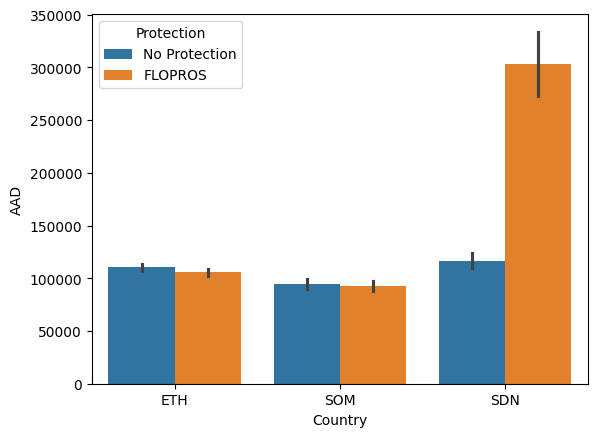

In [16]:
ax = sns.barplot(
    data=data_df,
    x="Country",
    y="Impact",
    hue="Protection",
    errorbar="se",
    estimator="mean",
    hue_order=["No Protection", "FLOPROS"],
)
# ax.set_yscale("log")
ax.set_ylabel("AAD")

In [17]:
return_periods = [2, 5, 10]
rec = []
for name, idx in grouped.groups.items():
    # country, protection, func_id = name
    values = data_df.loc[idx, "Impact"]
    pmd = calc_pmd(values.to_numpy(dtype="float"), return_periods)
    for rp, val in zip(return_periods, pmd):
        rec.append(name + (rp, val))

pmd_df = pd.DataFrame.from_records(
    rec, columns=["Country", "Protection", "Impact Func ID", "Return Period", "PMD"]
)
pmd_df

,Country,Protection,Impact Func ID,Return Period,PMD
0,ETH,FLOPROS,0,2,94032.710519
1,ETH,FLOPROS,0,5,142860.234059
2,ETH,FLOPROS,0,10,185715.817333
3,ETH,FLOPROS,1,2,94953.189530
4,ETH,FLOPROS,1,5,137623.990123
...,...,...,...,...,...
355,SOM,No Protection,18,5,125444.984185
356,SOM,No Protection,18,10,166172.470681
357,SOM,No Protection,19,2,62686.859022
358,SOM,No Protection,19,5,176016.933594


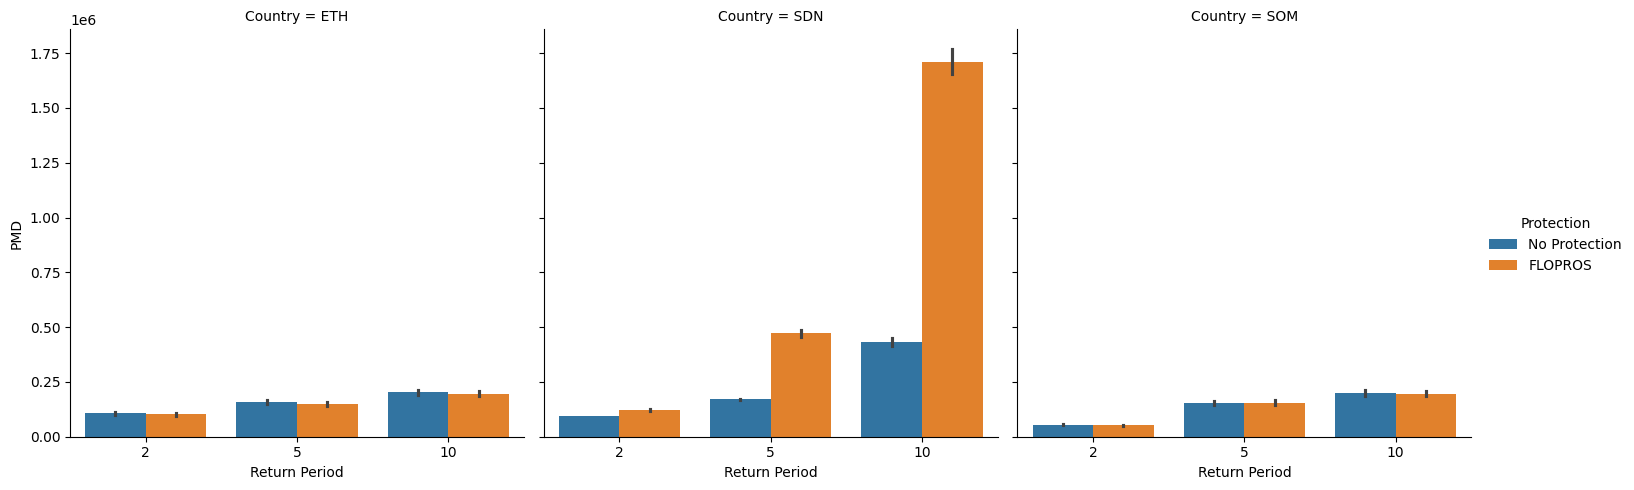

In [18]:
facet = sns.catplot(
    data=pmd_df,
    x="Return Period",
    y="PMD",
    hue="Protection",
    col="Country",
    # errorbar=("pi", 50),
    errorbar="ci",
    hue_order=["No Protection", "FLOPROS"],
    kind="bar",
    # palette={"no_protection": "C0", "flopros": "C1"},
)
# facet.set(yscale="log")

PMD Curve Fitting

In [19]:
# from climada.util.coordinates import country
import pycountry
from scipy.stats import rv_continuous
from scipy.stats import gumbel_r


def compare_return_periods(data: pd.DataFrame, gev: rv_continuous, method: str = "MLE"):

    for name, idx in data.groupby(["Country"]).groups.items():
        fig, axes = plt.subplots(
            1, 2, sharex=True, sharey=True, constrained_layout=True
        )
        fig.suptitle(name)
        group = data.loc[idx]

        observed = load_yearly_displacement_data(
            pycountry.countries.get(alpha_3=name).name
        )
        values = observed[country_to_iso(name, "numeric")].to_numpy()
        rp_obs, imp_obs = calc_pmd_full(values)

        params = gev.fit(values, method=method)
        func = gev(*params)
        # imp = np.linspace(gumb.ppf(0.01), gumb.ppf(0.99), 100)
        imp = np.linspace(np.min(imp_obs), np.max(imp_obs))
        rp = 1 / func.sf(imp)
        mask = rp > 1

        # Plot observations
        for ax in axes:
            ax.plot(rp_obs, imp_obs, "o-", color="k", zorder=10)

        axes[0].set_xscale("log")
        axes[0].set_yscale("log")
        axes[0].autoscale(False)
        axes[1].autoscale(False)

        axes[1].plot(rp[mask], imp[mask], "--", color="k", zorder=9)

        for prot, color in zip(group["Protection"].unique(), ("C0", "C1")):
            group_prot = group.loc[group["Protection"] == prot]
            for idx in group_prot.groupby(["Impact Func ID"]).groups.values():

                # rp, impacts = calc_pmd_full(values["Impact"])
                values = group_prot.loc[idx, "Impact"].to_numpy(dtype="float")

                # Plot calculated RPs
                rp, imp = calc_pmd_full(values)
                mask = rp > 1
                axes[0].plot(
                    rp[mask], imp[mask], "o-", color=color, alpha=0.5, markersize=2
                )

                # Plot Gumbel fit
                params = gev.fit(values, method=method)
                # print("c: {0}, loc: {1}, scale: {2}".format(*params))
                # print(*params)
                func = gev(*params)
                # imp = np.linspace(gumb.ppf(0.01), gumb.ppf(0.99), 100)
                imp = np.linspace(np.min(imp), np.max(imp))
                rp = 1 / func.sf(imp)
                mask = rp > 1
                axes[1].plot(rp[mask], imp[mask], color=color, alpha=0.5)

        axes[0].autoscale_view()

In [20]:
import numpy as np


def plot_fitted_distribution(
    values: np.ndarray, gev: rv_continuous, ax, method: str = "MLE", **plot_kwargs
):
    sns.kdeplot(x=values, ax=ax, ls="--", **plot_kwargs)
    sns.rugplot(x=values, ax=ax, height=0.05, **plot_kwargs)

    params = gev.fit(values, method=method)
    # print(params)
    func = gev(*params)
    x = np.linspace(func.ppf(0.01), func.ppf(0.99), 100)
    # print(func.ppf(0.01), func.ppf(0.99))
    # sns.lineplot(x=x, y=func.pdf(x), ax=ax, **plot_kwargs)
    ax.plot(x, func.pdf(x), **plot_kwargs)

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


(0.0, 2078220.258624826)

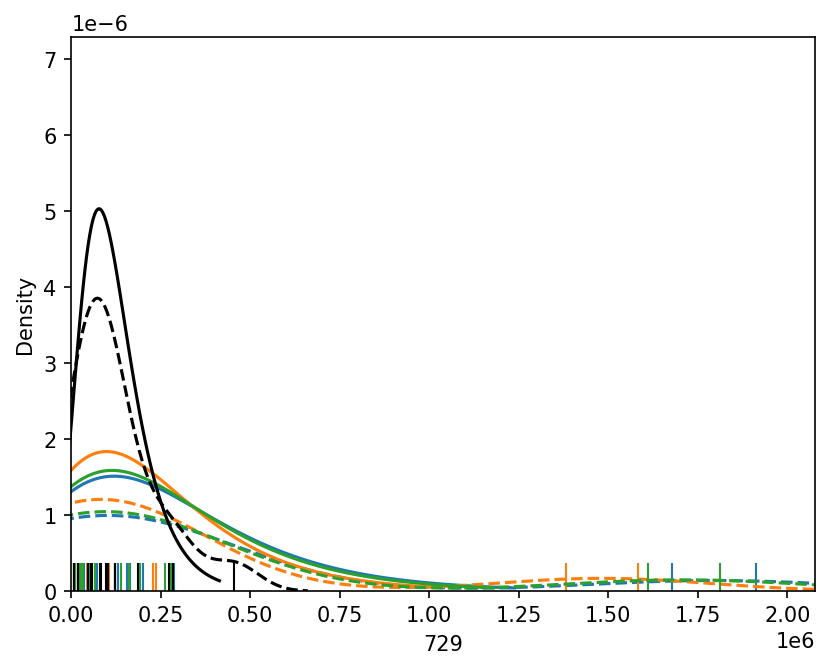

In [21]:
import scipy.stats as stat

country = "SDN"
data_subs = data_df.loc[
    (data_df["Country"] == country) & (data_df["Protection"] == "FLOPROS")
]

fig, ax = plt.subplots(dpi=150)
for func_id in range(3):
    plot_fitted_distribution(
        data_subs.loc[data_subs["Impact Func ID"] == func_id, "Impact"].to_numpy(
            dtype="float"
        ),
        gev=stat.gumbel_r,
        ax=ax,
        method="MLE",
        color=f"C{func_id}",
    )
data_true = load_yearly_displacement_data(country, ignore_zero_impact=False)
plot_fitted_distribution(
    data_true[data_true.columns[0]],
    gev=stat.gumbel_r,
    ax=ax,
    method="MLE",
    color="k",
)
ax.set_xlim(0, data_subs["Impact"].max())

/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")
/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")
/cluster/work/climate/ldr.riedel/displacement-mip/impact_calc.py:459: FutureWarning: 'y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("1y")


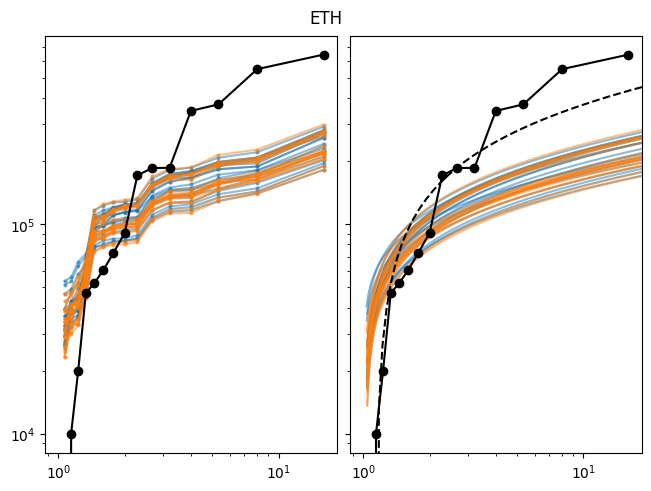

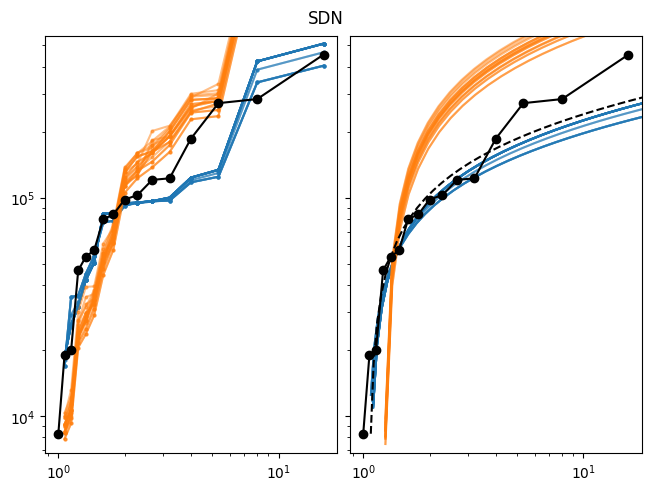

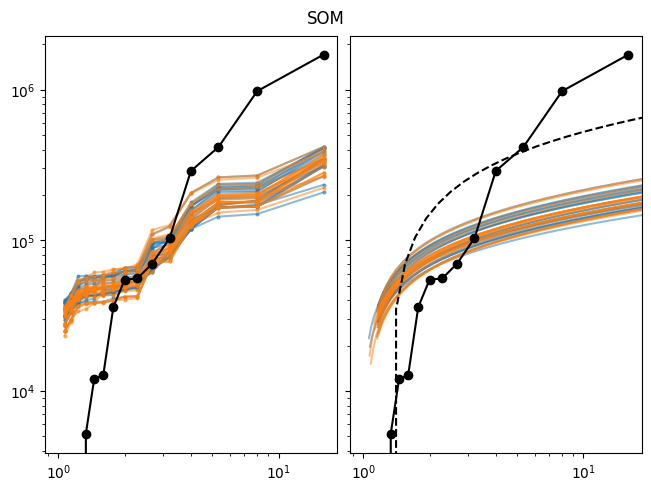

In [22]:
compare_return_periods(data_df, gev=gumbel_r)

In [23]:
def calc_pmd_gumbel(
    values: np.ndarray, return_periods: list[float], method: str = "MLE"
):
    """Return PMD for given return periods based on fitted Gumbel distribution"""
    # Fit gumbel distribution
    params = gumbel_r.fit(values, method=method)
    distr = gumbel_r(*params)
    impacts = np.linspace(distr.ppf(0.001), distr.ppf(0.999), 1000)
    rp = 1 / distr.sf(impacts)

    return np.interp(x=return_periods, xp=rp, fp=impacts), params

In [24]:
return_periods = [2, 5, 10, 25, 50, 100]
rec_pmd = []
rec_params = []
for name, idx in grouped.groups.items():
    # country, protection, func_id = name
    values = data_df.loc[idx, "Impact"]
    pmd, params = calc_pmd_gumbel(values.to_numpy(dtype="float"), return_periods)
    rec_params.append(name + params)
    for rp, val in zip(return_periods, pmd):
        rec_pmd.append(name + (rp, val))

pmd_gumbel_df = pd.DataFrame.from_records(
    rec_pmd, columns=["Country", "Protection", "Impact Func ID", "Return Period", "PMD"]
)
pmd_gumbel_df.to_csv("pmd.csv", index=False)
pmd_gumbel_df

,Country,Protection,Impact Func ID,Return Period,PMD
0,ETH,FLOPROS,0,2,80892.702217
1,ETH,FLOPROS,0,5,133095.313429
2,ETH,FLOPROS,0,10,167657.668438
3,ETH,FLOPROS,0,25,211327.744152
4,ETH,FLOPROS,0,50,243724.354535
...,...,...,...,...,...
715,SOM,No Protection,19,5,123655.373393
716,SOM,No Protection,19,10,151914.714209
717,SOM,No Protection,19,25,187620.832984
718,SOM,No Protection,19,50,214109.388346


In [25]:
gumbel_params_df = pd.DataFrame.from_records(
    rec_params, columns=["Country", "Protection", "Impact Func ID", "loc", "scale"]
)
gumbel_params_df

,Country,Protection,Impact Func ID,loc,scale
0,ETH,FLOPROS,0,64012.421776,46057.195625
1,ETH,FLOPROS,1,67875.515783,41996.214194
2,ETH,FLOPROS,2,70675.506050,39265.032646
3,ETH,FLOPROS,3,76089.031126,40637.040888
4,ETH,FLOPROS,4,65551.094122,38625.548335
...,...,...,...,...,...
115,SOM,No Protection,15,68004.276322,38675.496065
116,SOM,No Protection,16,63651.838078,33142.383324
117,SOM,No Protection,17,66391.089242,35186.418705
118,SOM,No Protection,18,50489.580901,26479.681159


In [26]:
# AAD
gumbel_params_df["AAD"] = (
    gumbel_params_df["loc"] + gumbel_params_df["scale"] * np.euler_gamma
)
gumbel_params_df.drop(columns=["loc", "scale"]).to_csv("aad.csv", index=False)
gumbel_params_df

,Country,Protection,Impact Func ID,loc,scale,AAD
0,ETH,FLOPROS,0,64012.421776,46057.195625,90597.356572
1,ETH,FLOPROS,1,67875.515783,41996.214194,92116.388483
2,ETH,FLOPROS,2,70675.506050,39265.032646,93339.897976
3,ETH,FLOPROS,3,76089.031126,40637.040888,99545.367701
4,ETH,FLOPROS,4,65551.094122,38625.548335,87846.365686
...,...,...,...,...,...,...
115,SOM,No Protection,15,68004.276322,38675.496065,90328.378499
116,SOM,No Protection,16,63651.838078,33142.383324,82782.140904
117,SOM,No Protection,17,66391.089242,35186.418705,86701.241311
118,SOM,No Protection,18,50489.580901,26479.681159,65774.067668


<Axes: xlabel='Country', ylabel='AAD'>

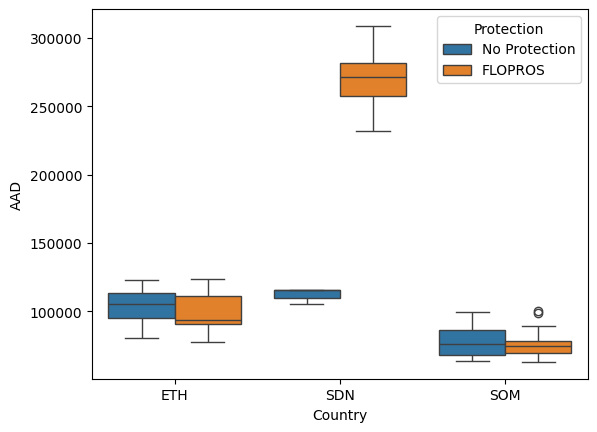

In [27]:
sns.boxplot(
    data=gumbel_params_df,
    x="Country",
    y="AAD",
    hue="Protection",
    hue_order=["No Protection", "FLOPROS"],
)

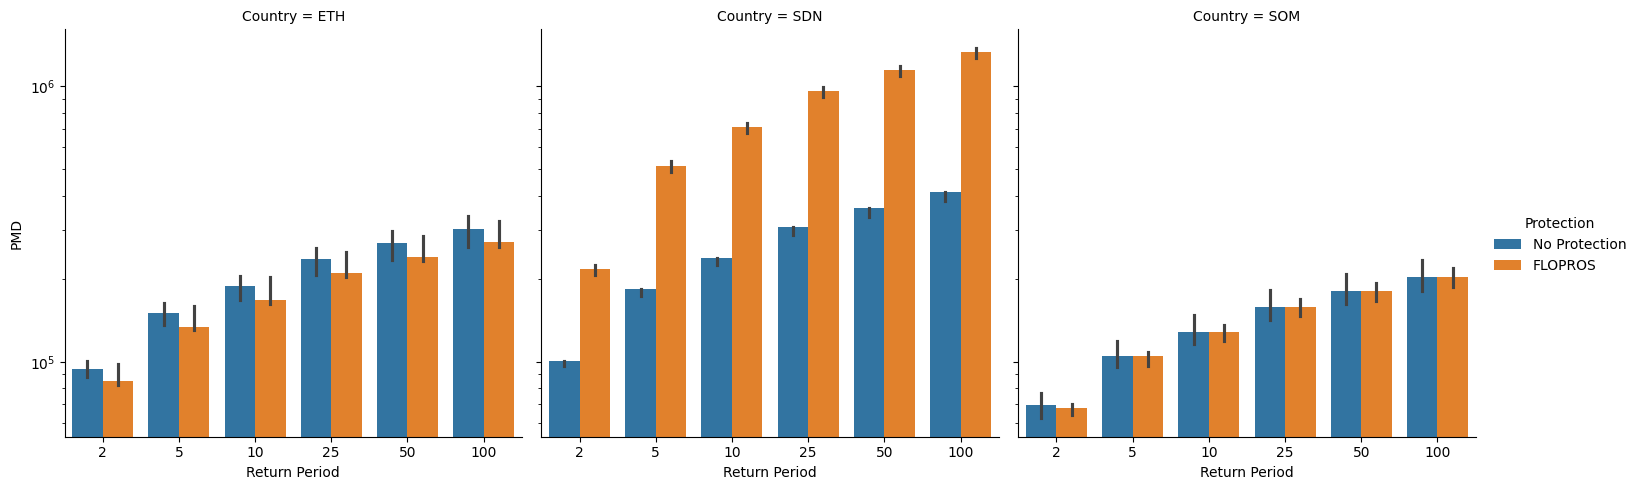

In [28]:
facet = sns.catplot(
    data=pmd_gumbel_df,
    x="Return Period",
    y="PMD",
    hue="Protection",
    col="Country",
    # errorbar=("pi", 50),
    estimator="median",
    errorbar="ci",
    hue_order=["No Protection", "FLOPROS"],
    kind="bar",
    # palette={"no_protection": "C0", "flopros": "C1"},
)
facet.axes[0, 0].set_yscale("log")